라이브러리 import, 학습 데이터 입력 ∙ 데이터 수정

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# 데이터 로드 
#종목코드가 포함된 열은 object형식으로 로드
stock_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData.csv',low_memory=False)
stock_df_pred = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Pred.csv',low_memory=False)

#labal 데이터프레임
label_df = stock_df['18']
#train 데이터프레임에서 label 값 삭제
stock_df = stock_df.drop({'18','7'},axis=1)
#예측에 필요한 데이터프레임
#학습에 필요한 데이터에서 Date제거
stock_df = stock_df.drop(columns='1')
stock_df_pred = stock_df_pred.drop('7',axis=1)
stock_df_pred = stock_df_pred.drop(columns='1')
# #종목코드 int형으로 변환
stock_df.astype({'0':'int'})
stock_df_pred.astype({'0':'int'})

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(stock_df, label_df, test_size=0.2, random_state=42)

# SMOTE를 사용해서 데이터 불균형 교정
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test,y_test)

LGBM 하이퍼 파라미터 튜닝(BayesianOptimization)

In [2]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMRegressor

bayesian_params = {
    'max_depth': (1,100),
    'min_child_samples': (1, 200), #하나의 잎에 최소 데이터 개수 (오버피팅 대응)
    "learning_rate": (0.001, 0.3),
    "num_leaves": (2,512),
    'scale_pos_weight': (0.1,20),
    'colsample_bytree': (0.0,1.0),
    'max_bin': (2,512),
    'min_child_samples': (1,500),
    'min_child_weight': (1,20),
    'reg_alpha': (0,20),
    'reg_lambda': (0,20),
    'subsample': (0.1,1),
    'feature_fraction': (0.1,1.0)
}

def lgb_roc_eval(max_depth, min_child_samples, num_leaves, min_child_weight, subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha, 
                 learning_rate, scale_pos_weight,feature_fraction):
  params = {
      "n_estimators": 500,
      'max_depth': int(round(max_depth)),
      'num_leaves': int(round(num_leaves)),
      'min_child_samples': int(round(min_child_samples)),
      'min_child_weight': int(round(min_child_weight)),
      'subsample': max(min(subsample, 1), 0),
      'colsample_bytree': max(min(colsample_bytree, 1), 0),
      'max_bin': max(int(round(max_bin)), 10),
      'reg_lambda': max(reg_lambda, 0),
      'reg_alpha': max(reg_alpha, 0),
      "learning_rate": learning_rate,
      "scale_pos_weight": scale_pos_weight,
      "feature_fraction": feature_fraction
  }
  lgb_model = LGBMRegressor(**params)
  lgb_model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_train_resampled, y_train_resampled), (X_test_resampled, y_test_resampled)], eval_metric= 'mse', verbose= 100, 
                early_stopping_rounds= 100)
  valid_proba = lgb_model.predict(X_test_resampled)
  roc_auc = roc_auc_score(y_test_resampled, valid_proba)

  return roc_auc

lgbBO = BayesianOptimization(f= lgb_roc_eval, pbounds=bayesian_params, random_state = 42)
lgbBO.maximize(init_points = 5, n_iter = 25)

# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

|   iter    |  target   | colsam... | featur... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9556428757689246, colsample_bytree=0.3745401188473625 will be ignored. Current value: feature_fraction=0.9556428757689246
[100]	training's l2: 0.0177048	valid_1's l2: 0.019493
[200]	training's l2: 0.0150402	valid_1's l2: 0.017615
[300]	training's l2: 0.0137232	valid_1's l2: 0.0168809
[400]	training's l2: 0.0129022	valid_1's l2: 0.016499
[500]	training's l2: 0.0122258	valid_1's l2: 0.0162569
| 1         | 0.9989    | 0.3745    | 0.9556    | 0.2199    | 307.3     | 16.45     | 78.84     | 2.104     | 443.7     | 12.02     | 14.16     | 0.5096    | 0.9729    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.29110519961044856, colsample_bytree=0.8324426408004217 will be ignored. Current value: feature_fraction=0.29110519961044856
[100]	training's l2: 0.0321066	valid_1's l2: 0.0309642
[200]	training's l2: 0.0272649	valid_1's l2: 0.0265982
[300]	training's l2: 0.024937	valid_1's l2: 0.0245541
[400]	training's l2: 0.0234482	valid_1's l2: 0.0232785
[500]	training's l2: 0.0223714	valid_1's l2: 0.02239
| 2         | 0.9979    | 0.8324    | 0.2911    | 0.05537   | 95.54     | 31.12     | 262.9     | 9.207     | 150.5     | 12.24     | 2.79      | 5.914     | 0.4297    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8066583652537123, colsample_bytree=0.45606998421703593 will be ignored. Current value: feature_fraction=0.8066583652537123
[100]	training's l2: 0.0316954	valid_1's l2: 0.0310978
[200]	training's l2: 0.0255495	valid_1's l2: 0.0253569
[300]	training's l2: 0.0224897	valid_1's l2: 0.0225286
[400]	training's l2: 0.0206664	valid_1's l2: 0.0208776
[500]	training's l2: 0.0195272	valid_1's l2: 0.0199067
| 3         | 0.9982    | 0.4561    | 0.8067    | 0.0607    | 264.3     | 59.65     | 24.18     | 12.54     | 88.97     | 1.301     | 18.98     | 19.32     | 0.8276    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.1879049026057455, colsample_bytree=0.3046137691733707 will be ignored. Current value: feature_fraction=0.1879049026057455
[100]	training's l2: 0.0238422	valid_1's l2: 0.0245912
[200]	training's l2: 0.0200148	valid_1's l2: 0.0216587
[300]	training's l2: 0.018085	valid_1's l2: 0.0203451
[400]	training's l2: 0.0168895	valid_1's l2: 0.0196526
[500]	training's l2: 0.0158981	valid_1's l2: 0.0190148
| 4         | 0.9984    | 0.3046    | 0.1879    | 0.2056    | 226.5     | 13.08     | 248.1     | 1.653     | 465.8     | 5.176     | 13.25     | 6.303     | 0.5681    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.26636900997297436, colsample_bytree=0.5467102793432796 will be ignored. Current value: feature_fraction=0.26636900997297436
[100]	training's l2: 0.0166154	valid_1's l2: 0.0182331
[200]	training's l2: 0.014002	valid_1's l2: 0.0166626
[300]	training's l2: 0.0124906	valid_1's l2: 0.0158568
[400]	training's l2: 0.011564	valid_1's l2: 0.0155399
[500]	training's l2: 0.0108167	valid_1's l2: 0.0153501
| 5         | 0.999     | 0.5467    | 0.2664    | 0.2909    | 397.3     | 94.01     | 447.5     | 12.36     | 472.2     | 1.77      | 3.92      | 1.0       | 0.3928    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7372527331448581, colsample_bytree=0.4857055407785523 will be ignored. Current value: feature_fraction=0.7372527331448581
[100]	training's l2: 0.0211417	valid_1's l2: 0.0215873
[200]	training's l2: 0.0177294	valid_1's l2: 0.0187245
[300]	training's l2: 0.0162418	valid_1's l2: 0.0176487
[400]	training's l2: 0.0152707	valid_1's l2: 0.017033
[500]	training's l2: 0.0145679	valid_1's l2: 0.0166456
| 6         | 0.9988    | 0.4857    | 0.7373    | 0.1228    | 280.6     | 83.45     | 248.8     | 11.7      | 217.3     | 3.813     | 19.47     | 0.5094    | 0.2118    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.755718341883725, colsample_bytree=0.6862159552172918 will be ignored. Current value: feature_fraction=0.755718341883725
[100]	training's l2: 0.0165584	valid_1's l2: 0.0182682
[200]	training's l2: 0.0141909	valid_1's l2: 0.0169575
[300]	training's l2: 0.0128565	valid_1's l2: 0.0164514
[400]	training's l2: 0.0118873	valid_1's l2: 0.0161601
[500]	training's l2: 0.0111302	valid_1's l2: 0.0159903
| 7         | 0.999     | 0.6862    | 0.7557    | 0.233     | 457.7     | 60.31     | 495.7     | 3.327     | 398.5     | 1.038     | 2.727     | 13.51     | 0.5601    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7158376535064556, colsample_bytree=0.8698428505318728 will be ignored. Current value: feature_fraction=0.7158376535064556
[100]	training's l2: 0.0372913	valid_1's l2: 0.0367162
[200]	training's l2: 0.0306197	valid_1's l2: 0.0305092
[300]	training's l2: 0.027779	valid_1's l2: 0.0280028
[400]	training's l2: 0.0260488	valid_1's l2: 0.0265481
[500]	training's l2: 0.0247388	valid_1's l2: 0.0254872
| 8         | 0.997     | 0.8698    | 0.7158    | 0.07125   | 41.34     | 94.38     | 310.1     | 9.394     | 119.5     | 2.521     | 4.887     | 15.24     | 0.1247    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.19552876919544807, colsample_bytree=0.8956816563888997 will be ignored. Current value: feature_fraction=0.19552876919544807
[100]	training's l2: 0.0249583	valid_1's l2: 0.024481
[200]	training's l2: 0.0217291	valid_1's l2: 0.0218189
[300]	training's l2: 0.0200081	valid_1's l2: 0.0205123
[400]	training's l2: 0.0187835	valid_1's l2: 0.0195828
[500]	training's l2: 0.0178809	valid_1's l2: 0.0189131
| 9         | 0.9984    | 0.8957    | 0.1955    | 0.06594   | 189.4     | 28.49     | 299.1     | 2.88      | 443.6     | 10.23     | 0.3762    | 15.4      | 0.596     |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5277914688977993, colsample_bytree=0.1546450876060621 will be ignored. Current value: feature_fraction=0.5277914688977993
[100]	training's l2: 0.0216698	valid_1's l2: 0.0219778
[200]	training's l2: 0.0182868	valid_1's l2: 0.0190288
[300]	training's l2: 0.01662	valid_1's l2: 0.0176465
[400]	training's l2: 0.0156548	valid_1's l2: 0.0168904
[500]	training's l2: 0.014923	valid_1's l2: 0.0163277
| 10        | 0.9989    | 0.1546    | 0.5278    | 0.07302   | 464.2     | 95.54     | 286.8     | 1.942     | 354.7     | 18.99     | 3.203     | 16.52     | 0.8192    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9129844790801571, colsample_bytree=0.7137379160566533 will be ignored. Current value: feature_fraction=0.9129844790801571
[100]	training's l2: 0.0346314	valid_1's l2: 0.0343849
[200]	training's l2: 0.0279498	valid_1's l2: 0.0279955
[300]	training's l2: 0.0247395	valid_1's l2: 0.0249847
[400]	training's l2: 0.0223426	valid_1's l2: 0.0227334
[500]	training's l2: 0.0207167	valid_1's l2: 0.0212244
| 11        | 0.9979    | 0.7137    | 0.913     | 0.04289   | 452.7     | 10.99     | 412.7     | 18.83     | 169.4     | 19.48     | 14.03     | 14.48     | 0.1272    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.573764697398043, colsample_bytree=0.43268006070572296 will be ignored. Current value: feature_fraction=0.573764697398043
[100]	training's l2: 0.0215852	valid_1's l2: 0.0220114
[200]	training's l2: 0.0182951	valid_1's l2: 0.0194243
[300]	training's l2: 0.0168965	valid_1's l2: 0.0185696
[400]	training's l2: 0.0158885	valid_1's l2: 0.0180205
[500]	training's l2: 0.0151209	valid_1's l2: 0.017638
| 12        | 0.9987    | 0.4327    | 0.5738    | 0.1839    | 168.3     | 97.26     | 87.27     | 15.02     | 165.1     | 2.788     | 8.98      | 15.1      | 0.2366    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.1827877300261855, colsample_bytree=0.6671312196519337 will be ignored. Current value: feature_fraction=0.1827877300261855
[100]	training's l2: 0.0739712	valid_1's l2: 0.0726289
[200]	training's l2: 0.059099	valid_1's l2: 0.0578857
[300]	training's l2: 0.0519135	valid_1's l2: 0.0507314
[400]	training's l2: 0.0476937	valid_1's l2: 0.0465617
[500]	training's l2: 0.0441794	valid_1's l2: 0.0430888
| 13        | 0.9933    | 0.6671    | 0.1828    | 0.1109    | 489.5     | 2.774     | 332.0     | 10.78     | 494.2     | 4.525     | 8.157     | 18.71     | 0.1882    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7005538170306752, colsample_bytree=0.3589361961479457 will be ignored. Current value: feature_fraction=0.7005538170306752
[100]	training's l2: 0.0232751	valid_1's l2: 0.02385
[200]	training's l2: 0.0187507	valid_1's l2: 0.0200244
[300]	training's l2: 0.0166553	valid_1's l2: 0.0184073
[400]	training's l2: 0.0153509	valid_1's l2: 0.017466
[500]	training's l2: 0.0143811	valid_1's l2: 0.0168111
| 14        | 0.9987    | 0.3589    | 0.7006    | 0.06401   | 311.4     | 16.39     | 75.26     | 19.6      | 442.7     | 4.561     | 4.965     | 3.143     | 0.126     |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.834836612287936, colsample_bytree=0.08027184129926324 will be ignored. Current value: feature_fraction=0.834836612287936
[100]	training's l2: 0.207971	valid_1's l2: 0.207721
[200]	training's l2: 0.174845	valid_1's l2: 0.174436
[300]	training's l2: 0.148475	valid_1's l2: 0.147985
[400]	training's l2: 0.127316	valid_1's l2: 0.126754
[500]	training's l2: 0.110363	valid_1's l2: 0.109767
| 15        | 0.988     | 0.08027   | 0.8348    | 0.001319  | 348.2     | 99.73     | 452.9     | 12.62     | 370.9     | 11.51     | 18.86     | 8.112     | 0.9801    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.3370184240094937, colsample_bytree=0.28184026080627844 will be ignored. Current value: feature_fraction=0.3370184240094937
[100]	training's l2: 0.0186921	valid_1's l2: 0.0200672
[200]	training's l2: 0.0160497	valid_1's l2: 0.0182924
[300]	training's l2: 0.0146254	valid_1's l2: 0.0175018
[400]	training's l2: 0.0137679	valid_1's l2: 0.0171485
[500]	training's l2: 0.0131282	valid_1's l2: 0.0169334
| 16        | 0.9989    | 0.2818    | 0.337     | 0.2792    | 206.3     | 44.05     | 318.0     | 14.54     | 372.4     | 8.407     | 17.67     | 3.61      | 0.696     |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6681150462358394, colsample_bytree=0.00799934758495835 will be ignored. Current value: feature_fraction=0.6681150462358394
[100]	training's l2: 0.0349493	valid_1's l2: 0.0349928
[200]	training's l2: 0.0269583	valid_1's l2: 0.0274468
[300]	training's l2: 0.0233283	valid_1's l2: 0.0241705
[400]	training's l2: 0.0209127	valid_1's l2: 0.0220295
[500]	training's l2: 0.0193221	valid_1's l2: 0.0206543
| 17        | 0.998     | 0.007999  | 0.6681    | 0.04735   | 317.0     | 8.857     | 75.44     | 15.0      | 445.9     | 1.023     | 2.135     | 12.11     | 0.4751    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.14523040434701792, colsample_bytree=0.841374603439832 will be ignored. Current value: feature_fraction=0.14523040434701792
[100]	training's l2: 0.0705691	valid_1's l2: 0.0696341
[200]	training's l2: 0.0367431	valid_1's l2: 0.0358075
[300]	training's l2: 0.0285384	valid_1's l2: 0.027759
[400]	training's l2: 0.0259877	valid_1's l2: 0.0253607
[500]	training's l2: 0.0246281	valid_1's l2: 0.0241333
| 18        | 0.9971    | 0.8414    | 0.1452    | 0.01219   | 402.4     | 54.86     | 107.9     | 12.33     | 399.8     | 12.67     | 10.15     | 4.395     | 0.3166    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.1643057018172753, colsample_bytree=0.28974989945273366 will be ignored. Current value: feature_fraction=0.1643057018172753
[100]	training's l2: 0.0214647	valid_1's l2: 0.0223791
[200]	training's l2: 0.0177538	valid_1's l2: 0.0194329
[300]	training's l2: 0.0160234	valid_1's l2: 0.0181568
[400]	training's l2: 0.0151489	valid_1's l2: 0.0176567
[500]	training's l2: 0.0143363	valid_1's l2: 0.0171304
| 19        | 0.9989    | 0.2897    | 0.1643    | 0.271     | 467.3     | 75.16     | 31.86     | 7.088     | 380.4     | 12.99     | 18.15     | 12.15     | 0.9998    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.9219206197495257, colsample_bytree=0.830755759774826 will be ignored. Current value: feature_fraction=0.9219206197495257
[100]	training's l2: 0.0277539	valid_1's l2: 0.0274717
[200]	training's l2: 0.0222583	valid_1's l2: 0.0223275
[300]	training's l2: 0.0199568	valid_1's l2: 0.0202545
[400]	training's l2: 0.0186265	valid_1's l2: 0.0190943
[500]	training's l2: 0.0177066	valid_1's l2: 0.0183383
| 20        | 0.9985    | 0.8308    | 0.9219    | 0.1324    | 498.4     | 51.76     | 27.07     | 10.29     | 56.25     | 4.043     | 11.38     | 1.798     | 0.2873    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.980674575995681, colsample_bytree=0.5823417962578278 will be ignored. Current value: feature_fraction=0.980674575995681
[100]	training's l2: 0.0183359	valid_1's l2: 0.0194097
[200]	training's l2: 0.0156105	valid_1's l2: 0.0172461
[300]	training's l2: 0.0143031	valid_1's l2: 0.016346
[400]	training's l2: 0.013482	valid_1's l2: 0.0158815
[500]	training's l2: 0.0128655	valid_1's l2: 0.0155819
| 21        | 0.999     | 0.5823    | 0.9807    | 0.1165    | 467.4     | 75.34     | 488.5     | 5.15      | 482.7     | 12.82     | 13.68     | 6.319     | 0.6511    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6468848723112275, colsample_bytree=0.5073844429016284 will be ignored. Current value: feature_fraction=0.6468848723112275
[100]	training's l2: 0.0257588	valid_1's l2: 0.0260104
[200]	training's l2: 0.0212303	valid_1's l2: 0.0220286
[300]	training's l2: 0.0188191	valid_1's l2: 0.019974
[400]	training's l2: 0.0173744	valid_1's l2: 0.0187729
[500]	training's l2: 0.0164395	valid_1's l2: 0.0180463
| 22        | 0.9984    | 0.5074    | 0.6469    | 0.05216   | 308.5     | 13.54     | 70.17     | 13.03     | 436.8     | 13.52     | 8.667     | 6.297     | 0.3355    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.7528103536470625, colsample_bytree=0.30371308544067077 will be ignored. Current value: feature_fraction=0.7528103536470625
[100]	training's l2: 0.0175267	valid_1's l2: 0.0193179
[200]	training's l2: 0.015158	valid_1's l2: 0.0177395
[300]	training's l2: 0.0139339	valid_1's l2: 0.0171027
[400]	training's l2: 0.013165	valid_1's l2: 0.0167946
[500]	training's l2: 0.012561	valid_1's l2: 0.016612
| 23        | 0.9989    | 0.3037    | 0.7528    | 0.2942    | 310.1     | 18.39     | 59.88     | 9.703     | 439.4     | 16.99     | 2.033     | 8.001     | 0.5623    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.954771571133034, colsample_bytree=0.1044630839701336 will be ignored. Current value: feature_fraction=0.954771571133034
[100]	training's l2: 0.0162727	valid_1's l2: 0.0183458
[200]	training's l2: 0.0140529	valid_1's l2: 0.0171281
[300]	training's l2: 0.0128999	valid_1's l2: 0.0167182
[400]	training's l2: 0.0120631	valid_1's l2: 0.016475
[500]	training's l2: 0.0113968	valid_1's l2: 0.0163136
| 24        | 0.9989    | 0.1045    | 0.9548    | 0.2509    | 285.7     | 94.9      | 56.32     | 18.1      | 475.7     | 11.53     | 12.55     | 6.237     | 0.1181    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8585469107134702, colsample_bytree=0.7127646651329405 will be ignored. Current value: feature_fraction=0.8585469107134702
[100]	training's l2: 0.0167633	valid_1's l2: 0.0190814
[200]	training's l2: 0.0138435	valid_1's l2: 0.0174503
[300]	training's l2: 0.0123666	valid_1's l2: 0.0168988
[400]	training's l2: 0.0113438	valid_1's l2: 0.0166022
[500]	training's l2: 0.0105586	valid_1's l2: 0.0164199
| 25        | 0.9988    | 0.7128    | 0.8585    | 0.2284    | 239.5     | 25.37     | 21.35     | 18.34     | 480.4     | 5.572     | 3.126     | 2.13      | 0.1994    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5479272502154484, colsample_bytree=0.4239876251005311 will be ignored. Current value: feature_fraction=0.5479272502154484
[100]	training's l2: 0.0172792	valid_1's l2: 0.0191992
[200]	training's l2: 0.0147434	valid_1's l2: 0.0177658
[300]	training's l2: 0.0133768	valid_1's l2: 0.0171965
[400]	training's l2: 0.0124412	valid_1's l2: 0.0168722
[500]	training's l2: 0.01174	valid_1's l2: 0.016694
| 26        | 0.9989    | 0.424     | 0.5479    | 0.2964    | 253.7     | 33.13     | 84.52     | 8.893     | 397.7     | 7.472     | 13.06     | 0.107     | 0.1298    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8550044745398632, colsample_bytree=0.31168789450082646 will be ignored. Current value: feature_fraction=0.8550044745398632
[100]	training's l2: 0.020776	valid_1's l2: 0.0214885
[200]	training's l2: 0.0172395	valid_1's l2: 0.0184975
[300]	training's l2: 0.0157516	valid_1's l2: 0.0173889
[400]	training's l2: 0.0148201	valid_1's l2: 0.0167479
[500]	training's l2: 0.0141592	valid_1's l2: 0.0163292
| 27        | 0.9989    | 0.3117    | 0.855     | 0.07204   | 255.6     | 80.46     | 147.2     | 2.311     | 497.6     | 14.75     | 5.718     | 1.029     | 0.7095    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5993578725235558, colsample_bytree=0.18024173412661249 will be ignored. Current value: feature_fraction=0.5993578725235558
[100]	training's l2: 0.0176497	valid_1's l2: 0.0193545
[200]	training's l2: 0.0150082	valid_1's l2: 0.0179412
[300]	training's l2: 0.0135647	valid_1's l2: 0.0173925
[400]	training's l2: 0.012538	valid_1's l2: 0.0170727
[500]	training's l2: 0.011748	valid_1's l2: 0.0168817
| 28        | 0.9988    | 0.1802    | 0.5994    | 0.2626    | 215.4     | 64.55     | 206.1     | 6.775     | 343.0     | 1.979     | 15.92     | 14.31     | 0.1448    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.268845598793141, colsample_bytree=0.6654654221065188 will be ignored. Current value: feature_fraction=0.268845598793141
[100]	training's l2: 0.0331996	valid_1's l2: 0.0321221
[200]	training's l2: 0.025248	valid_1's l2: 0.0246631
[300]	training's l2: 0.0229138	valid_1's l2: 0.0226124
[400]	training's l2: 0.0215161	valid_1's l2: 0.0214086
[500]	training's l2: 0.0205264	valid_1's l2: 0.0205824
| 29        | 0.998     | 0.6655    | 0.2688    | 0.02853   | 483.3     | 74.98     | 491.3     | 13.39     | 211.8     | 3.385     | 10.11     | 14.63     | 0.4359    |


/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/moon/anaconda3/envs/mulcamp/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5210711150479999, colsample_bytree=0.39252505150351147 will be ignored. Current value: feature_fraction=0.5210711150479999
[100]	training's l2: 0.0191628	valid_1's l2: 0.0203948
[200]	training's l2: 0.0164624	valid_1's l2: 0.0185706
[300]	training's l2: 0.0150594	valid_1's l2: 0.0178255
[400]	training's l2: 0.0141169	valid_1's l2: 0.0173926
[500]	training's l2: 0.0134272	valid_1's l2: 0.0171454
| 30        | 0.9988    | 0.3925    | 0.5211    | 0.2893    | 224.8     | 49.52     | 144.0     | 6.52      | 247.6     | 7.099     | 8.925     | 17.97     | 0.6969    |
[0.9988992860713903, 0.9978891772830202, 0.9982468340244961, 0.9983876435321389, 0.9990180970386014, 0.9988485782362696, 0.9989980880189153, 0.9969553586929063, 0.9983797860592493, 0.998912118902798, 0.997883538581525, 0.9987434987388284, 0.9933338210481824, 0.998660848151018, 0.9879629798167278, 0.9988900582139149, 0.9979516854657398, 0.9970691343731175, 0.9988759417051214, 0.99853

LGBM Regressor 모델 생성 ∙ 학습

In [3]:
# LightGBM 모델 파라미터 설정
params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "metric": "mse",
    'max_depth': 75,
    'feature_fraction': 0.98,
    'early_stopping_round': 20,
    "learning_rate": 0.11,
    "num_leaves": 482,
    'scale_pos_weight': 6.3,
    'colsample_bytree': 0.58,
    'max_bin': 467,ß
    'min_child_samples': 488,
    'min_child_weight': 5.15,
    'reg_alpha': 12.8,
    'reg_lambda': 13.6,
    'subsample': 0.65,
    'num_threads': 8
}

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)
test_data = lgb.Dataset(X_test_resampled, label=y_test_resampled)

num_round = 10000
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
asdf = lgb.LGBMRegressor()

y_pred = bst.predict(X_test)
# 평가 지표 계산
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {accuracy}, AUC: {auc}')


[LightGBM] [Warning] feature_fraction is set=0.98, colsample_bytree=0.58 will be ignored. Current value: feature_fraction=0.98
[LightGBM] [Warning] feature_fraction is set=0.98, colsample_bytree=0.58 will be ignored. Current value: feature_fraction=0.98
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13543
[LightGBM] [Info] Number of data points in the train set: 3459718, number of used features: 29
[LightGBM] [Warning] feature_fraction is set=0.98, colsample_bytree=0.58 will be ignored. Current value: feature_fraction=0.98
[LightGBM] [Info] Start training from score 0.500000
[1]	valid_0's l2: 0.211392
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 0.180685
[3]	valid_0's l2: 0.154777
[4]	valid_0's l2: 0.134428
[5]	valid_0's l2: 0.117782
[6]	valid_0's l2: 0.104932
[7]	valid_0's l2: 0.093862
[8]	valid_0's l2: 0.0

KeyboardInterrupt: 

LGBM Regressor 모델 평가 지표

In [ ]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n',confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

preds_id = np.where(y_pred > 0.5,True,False)

get_clf_eval(y_test,preds_id)

오차행렬:
 [[428942   3423]
 [  7300  15562]]

정확도: 0.9764
정밀도: 0.8197
재현율: 0.6807
F1: 0.7438
AUC: 0.8364


내일 5%이상 오를 종목 예측

In [ ]:
def make_six_digit_list(input_list):
    six_digit_list = []

    for item in input_list:
        # 현재 항목의 길이를 확인
        item_str = str(item)
        item_len = len(item_str)

        if item_len < 6:
            # 6자리가 안되는 항목은 앞에 0을 채워서 6자리로 만듭니다.
            zero_padding = '0' * (6 - item_len)
            six_digit_item = zero_padding + item_str
            six_digit_list.append(six_digit_item)
        else:
            # 이미 6자리인 경우 그대로 유지
            six_digit_list.append(item_str)

    return six_digit_list

In [ ]:
# 내일 주가 예측
pred_X = stock_df_pred
predictions = bst.predict(pred_X,predict_disable_shape_check=True)
# 5% 이상 오를 종목 식별
threshold = 0.5
rising_stocks = [ticker for i, ticker in enumerate(stock_df_pred['0']) if predictions[i] > threshold]
rising_stocks = list(map(str, rising_stocks))
result = list(set(rising_stocks))
result = make_six_digit_list(result)
print("내일 5% 이상 상승할 종목:", result)
print(len(result))

내일 5% 이상 상승할 종목: ['001527', '138490', '014530', '004560', '010060', '286940', '004830', '006880', '003160', '000490', '014915', '011210', '241590', '010600', '034020', '000890', '023960', '229640', '003090', '001940', '138040', '017370', '010820', '001530', '002140', '002880', '002360', '028670', '008930', '003780', '001080', '008600', '016710', '103590', '152550', '025540', '011760', '000040', '009810', '003610', '012170', '126720', '210980', '001780', '008355', '192650', '018470', '031820', '375500', '004090', '034730', '005870', '009415', '003850', '117580', '004100', '021050', '005110', '013520', '004840', '058430', '002710', '004270', '069620', '000155', '002070', '007460', '011810', '033250', '128940', '403550', '001380', '018670', '285130', '000400', '003220', '000325', '003010', '026940', '033240', '006370', '039490', '008350', '016880', '011155', '200880', '019180', '002630', '016740', '066570', '006650', '009420', '071090', '007210', '128820', '009830', '044380', '005420', '0

예측한 종목 검증

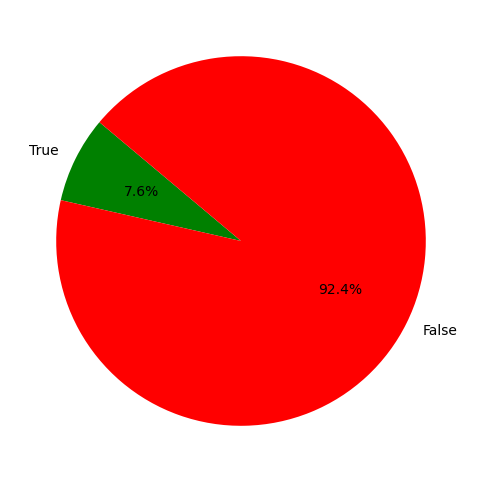

In [ ]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

def check_price_increase(stock_codes):
    result = {}
    
    for code in stock_codes:
        df = fdr.DataReader(code,'2023-10-12','2023-10-13')
        
        if len(df) < 2:
            result[code] = False
        else:
            today_close = df['Close'].iloc[-1]
            yesterday_close = df['Close'].iloc[-2]
            
            if today_close >= yesterday_close * 1.05 :
                result[code] = True
            else:
                result[code] = False
    return result

result_TF = check_price_increase(result)
result_TF = list(result_TF.values())

# True와 False의 개수를 세어 비율을 계산
true_count = sum(result_TF)
false_count = len(result_TF) - true_count

# 비율을 파이그래프로 표현
labels = ['True', 'False']
sizes = [true_count, false_count]
colors = ['green', 'red']

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# 그래프 표시
plt.show()